In [1]:
import wntr
import matplotlib.pyplot as plt
import matplotlib
import numpy

In [2]:
inpfile='./Net3.inp'

In [3]:
wn=wntr.network.WaterNetworkModel(inpfile)

In [4]:
population=wntr.metrics.population(wn)

In [5]:
population

10         0.0
15      1902.0
20         0.0
35     12371.0
40         0.0
        ...   
267        0.0
269        0.0
271        0.0
273        0.0
275        0.0
Length: 92, dtype: float64

In [6]:
startTime=2*3600
fireDuration=4*3600

totalDuration=startTime+fireDuration
fire_demand=0.5047
minimumPressure=3.52 
requiredPressure=14.06

minPipediameter=0.1524 # 6 inch
maxPipediameter=0.2032 # 8 inch



In [11]:
averageExpecteddemandJunc=wntr.metrics.average_expected_demand(wn)
nonZeroJunctions=averageExpecteddemandJunc[averageExpecteddemandJunc>0].index

In [34]:
averageExpecteddemandJunc


10     0.000000
15     0.016666
20     0.000000
35     0.108389
40     0.000000
         ...   
267    0.000000
269    0.000000
271    0.000000
273    0.000000
275    0.000000
Length: 92, dtype: float64

In [14]:
wn.options.hydraulic.demand_model='PDD'
wn.options.time.duration=totalDuration
wn.options.hydraulic.minimum_pressure=minimumPressure
wn.options.hydraulic.required_pressure=requiredPressure

In [15]:
sim=wntr.sim.WNTRSimulator(wn)
results=sim.run_sim()

In [16]:
pressure=results.node['pressure'].loc[startTime:,nonZeroJunctions]

In [17]:
NormalPressureBelowMin=pressure.columns[(pressure<3.52).any()]

In [18]:
len(NormalPressureBelowMin)

0

In [19]:
pipeDiameter=wn.query_link_attribute('diameter')

In [20]:
pipeDiameter

20     2.5146
40     2.5146
50     2.5146
60     0.6096
101    0.4572
        ...  
323    0.3048
325    0.2032
329    0.7620
330    0.7620
333    0.7620
Length: 117, dtype: float64

In [21]:
pipesOfInterest=pipeDiameter[(pipeDiameter<=maxPipediameter)&(pipeDiameter>=minPipediameter)]

In [36]:
pipesOfInterest

114    0.2032
115    0.2032
122    0.2032
145    0.2032
147    0.2032
149    0.2032
151    0.2032
161    0.2032
169    0.2032
185    0.2032
186    0.2032
202    0.2032
203    0.2032
209    0.2032
221    0.2032
261    0.2032
271    0.2032
293    0.2032
297    0.2032
299    0.2032
301    0.2032
303    0.2032
309    0.2032
317    0.2032
325    0.2032
dtype: float64

In [23]:
junctionsOfInterest=set()
for pipe_name in pipesOfInterest.index:
    pipe=wn.get_link(pipe_name)
    if pipe.start_node_name in wn.junction_name_list:
        junctionsOfInterest.add(pipe.start_node_name)
    if pipe.end_node_name in wn.junction_name_list:
        junctionsOfInterest.add(pipe.end_node_name)
    

In [29]:
analysisResults={}
for junction in junctionsOfInterest:
    wn=wntr.network.WaterNetworkModel(inpfile)
    wn.options.hydraulic.demand_model='PDD'
    wn.options.time.duration=totalDuration
    wn.options.hydraulic.minimum_pressure=minimumPressure
    wn.options.hydraulic.required_pressure=requiredPressure

    fireFlowpattern=wntr.network.elements.Pattern.binary_pattern('fireflow',
                                                start_time=startTime,
                                                end_time=totalDuration,
                                                step_size=wn.options.time.pattern_timestep,
                                                duration=wn.options.time.duration)
    wn.add_pattern('fireflow',fireFlowpattern)
    fireJunction=wn.get_node(junction)
    fireJunction.demand_timeseries_list.append((fire_demand,fireFlowpattern,'Fire Flow'))

    sim=wntr.sim.WNTRSimulator(wn)
    sim_results=sim.run_sim()
    sim_pressure=sim_results.node['pressure'].loc[startTime:,nonZeroJunctions]
    sim_pressure_below_pmin=sim_pressure.columns[(sim_pressure<minimumPressure).any()]
    impacted_junctions= set(sim_pressure_below_pmin)-set(NormalPressureBelowMin)

    impacted_junctions=list(impacted_junctions)
    analysisResults[junction]=impacted_junctions

In [30]:
analysisResults

{'115': [],
 '204': [],
 '107': [],
 '15': [],
 '153': [],
 '141': ['15'],
 '129': [],
 '251': [],
 '187': [],
 '259': [],
 '183': [],
 '273': [],
 '195': [],
 '275': [],
 '167': [],
 '184': [],
 '257': [],
 '261': [],
 '149': [],
 '255': ['253'],
 '265': [],
 '113': [],
 '237': ['255', '251', '253'],
 '263': [],
 '169': [],
 '189': [],
 '161': [],
 '151': ['153'],
 '139': [],
 '269': [],
 '143': ['15'],
 '213': ['255', '251', '253'],
 '121': [],
 '120': [],
 '267': [],
 '271': [],
 '185': [],
 '229': [],
 '125': []}

In [40]:
num_junctions_impacted={}
num_people_impacted={}
for pipe_name,impacted_junctions in analysisResults.items():
    if impacted_junctions is not None:
        num_junctions_impacted[pipe_name]=len(impacted_junctions)
        num_people_impacted[pipe_name]=population[impacted_junctions].sum()

In [41]:
num_junctions_impacted

{'115': 0,
 '204': 0,
 '107': 0,
 '15': 0,
 '153': 0,
 '141': 1,
 '129': 0,
 '251': 0,
 '187': 0,
 '259': 0,
 '183': 0,
 '273': 0,
 '195': 0,
 '275': 0,
 '167': 0,
 '184': 0,
 '257': 0,
 '261': 0,
 '149': 0,
 '255': 1,
 '265': 0,
 '113': 0,
 '237': 3,
 '263': 0,
 '169': 0,
 '189': 0,
 '161': 0,
 '151': 1,
 '139': 0,
 '269': 0,
 '143': 1,
 '213': 3,
 '121': 0,
 '120': 0,
 '267': 0,
 '271': 0,
 '185': 0,
 '229': 0,
 '125': 0}

In [42]:
num_people_impacted

{'115': 0.0,
 '204': 0.0,
 '107': 0.0,
 '15': 0.0,
 '153': 0.0,
 '141': 1902.0,
 '129': 0.0,
 '251': 0.0,
 '187': 0.0,
 '259': 0.0,
 '183': 0.0,
 '273': 0.0,
 '195': 0.0,
 '275': 0.0,
 '167': 0.0,
 '184': 0.0,
 '257': 0.0,
 '261': 0.0,
 '149': 0.0,
 '255': 420.0,
 '265': 0.0,
 '113': 0.0,
 '237': 917.0,
 '263': 0.0,
 '169': 0.0,
 '189': 0.0,
 '161': 0.0,
 '151': 340.0,
 '139': 0.0,
 '269': 0.0,
 '143': 1902.0,
 '213': 917.0,
 '121': 0.0,
 '120': 0.0,
 '267': 0.0,
 '271': 0.0,
 '185': 0.0,
 '229': 0.0,
 '125': 0.0}

<BarContainer object of 39 artists>

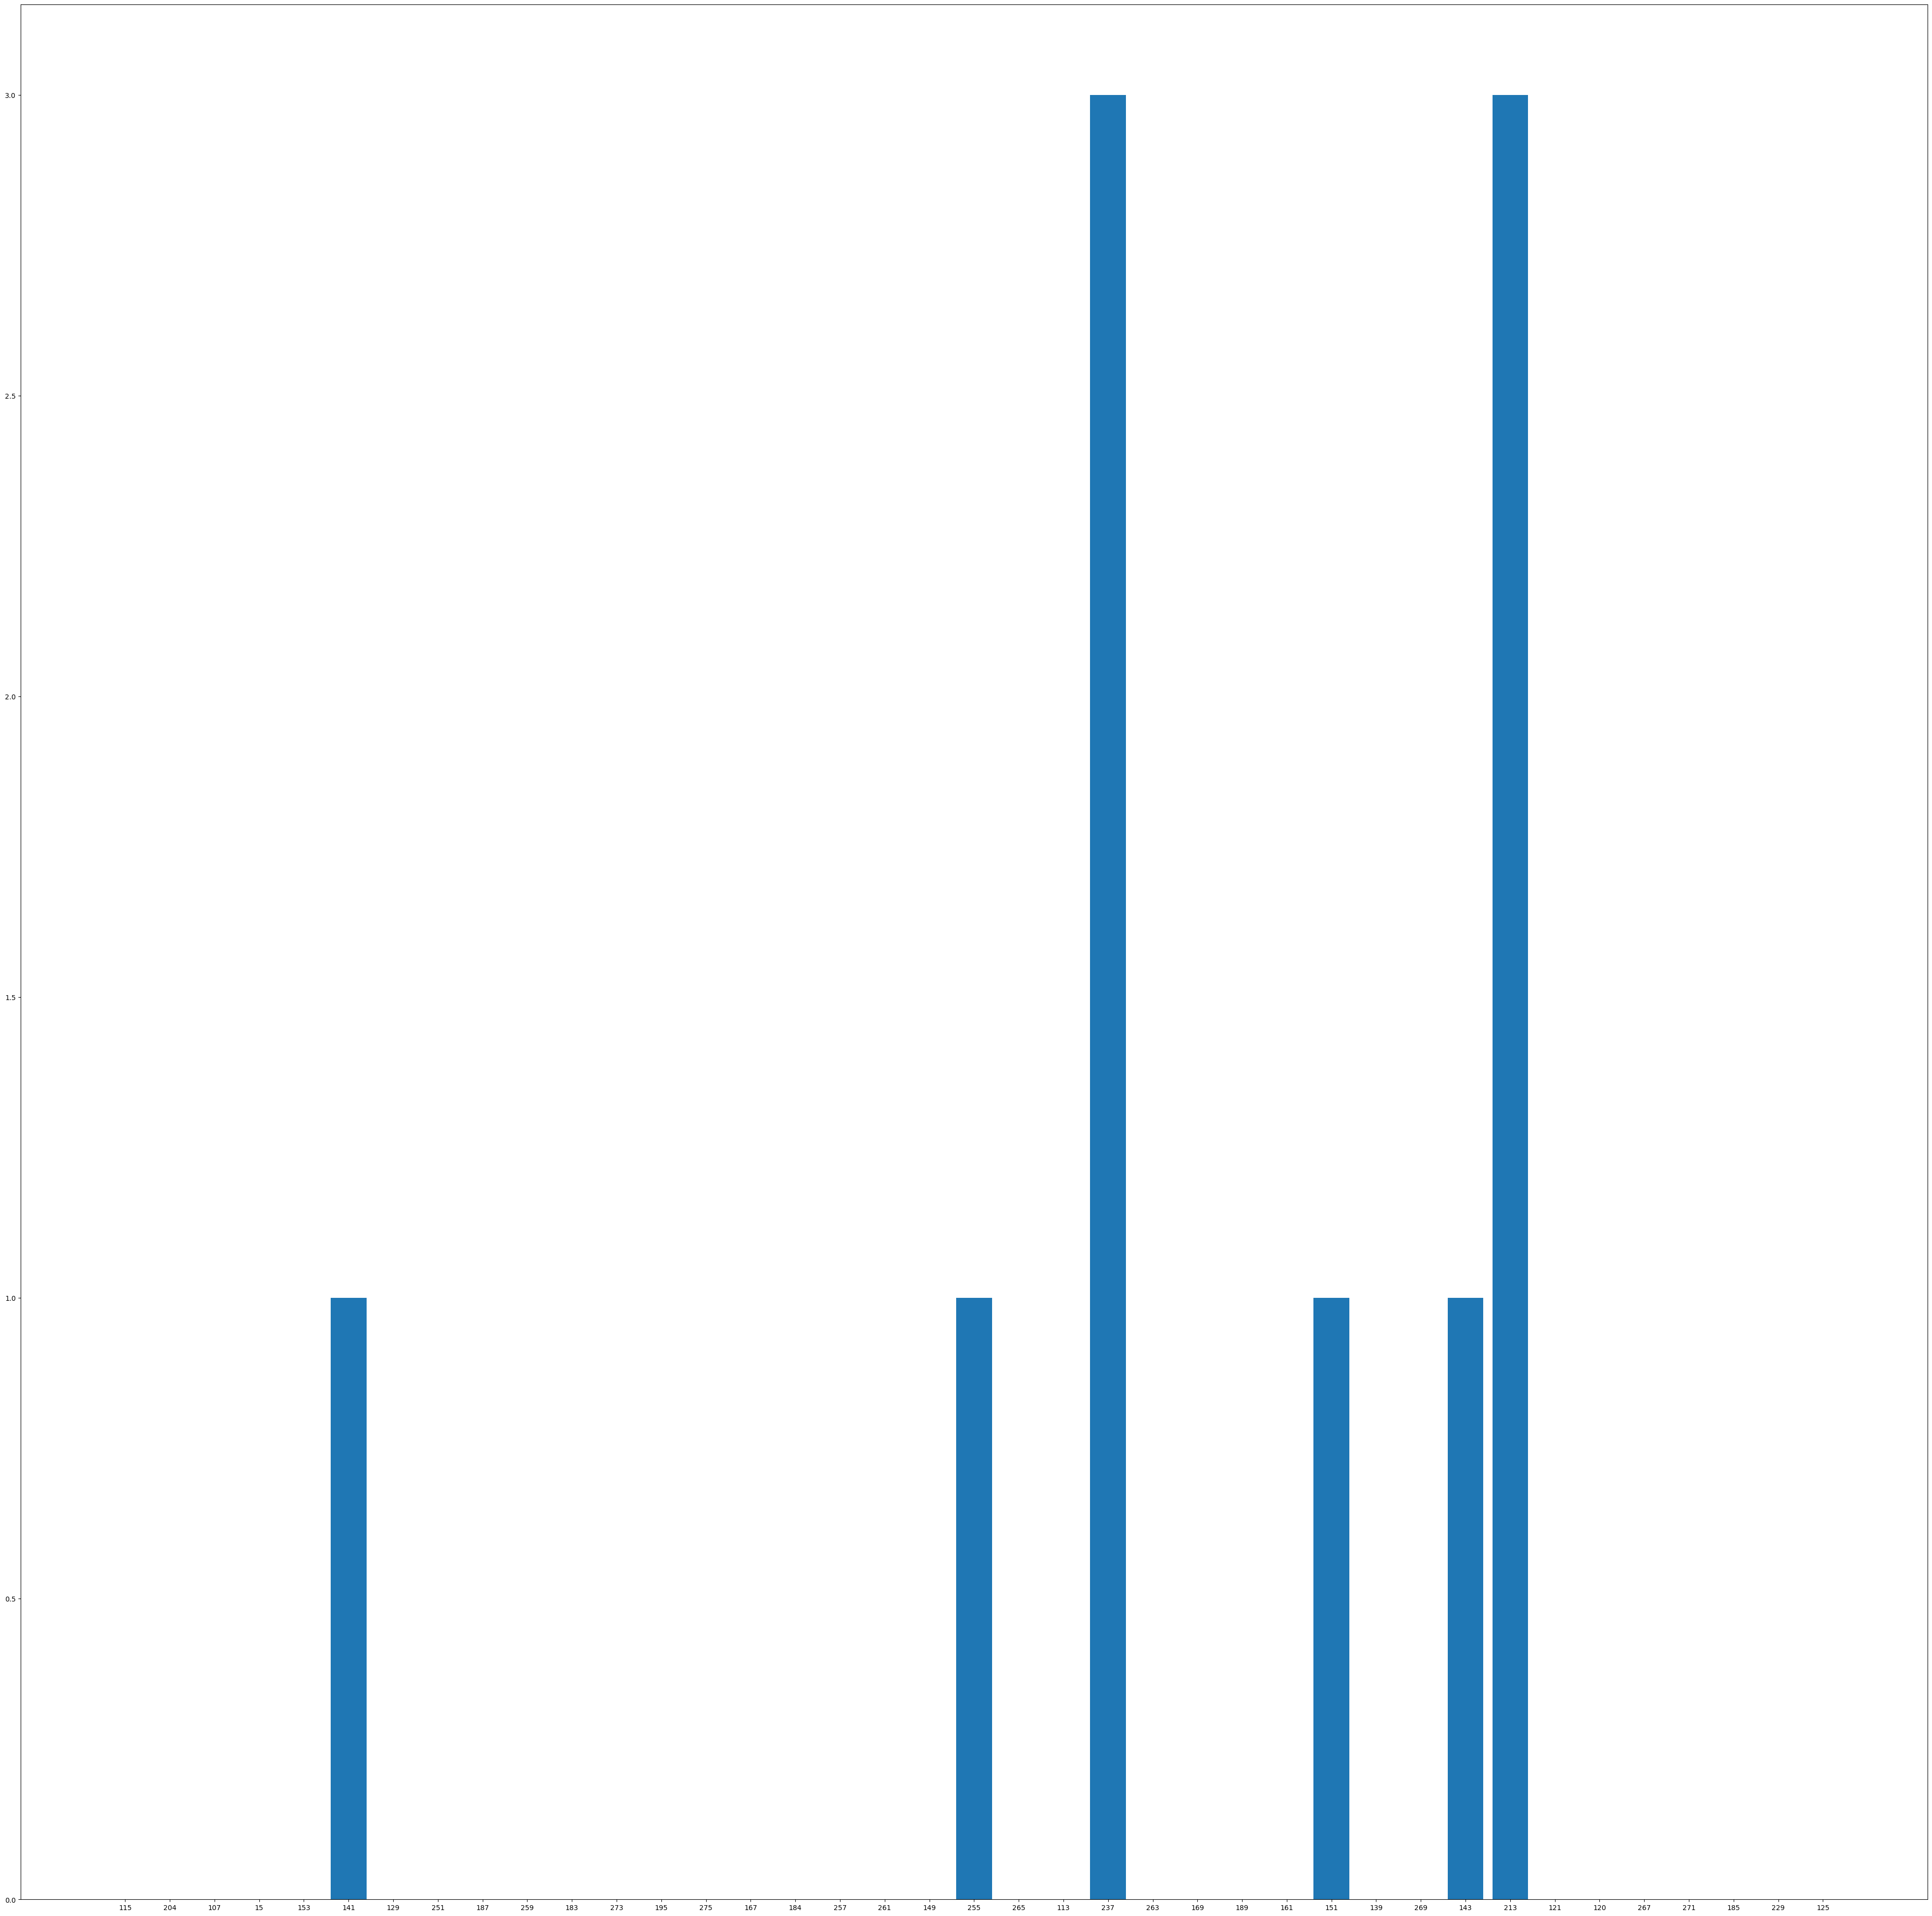

In [44]:
plt.figure(figsize=(,50))
plt.bar(num_junctions_impacted.keys(),num_junctions_impacted.values())